In [1]:
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import h5py
import cv2
import os
import sys

import matplotlib
import matplotlib.pyplot as plt


ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
# Path to the processed and raw folders in the data
PROCESSED_PATH = os.path.join(ROOT_DIR, "../data/processed/")
RAW_PATH = os.path.join(ROOT_DIR, "../data/raw/")
MODEL_PATH = os.path.join(ROOT_DIR,"../models/")


data_file_name = "Football1"

model_name = "Mask_only_Simple_Unet"



model_folder = os.path.join(MODEL_PATH, "{}/".format(model_name))
model_file = os.path.join(MODEL_PATH, "{}/{}.pkl".format(model_name,model_name))
model_history_file = os.path.join(MODEL_PATH, "{}/{}_history.pkl".format(model_name,model_name))




from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
import numpy as np
from preprocessing.utils import visualise_image, visualise_masks
from scipy.spatial import distance


/opt/Python/Python-3.6/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/opt/Python/Python-3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3,padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8,16,3,padding=1)
        self.conv3 = nn.Conv2d(16,32,3,padding=1)
        
        self.deconv1 = nn.ConvTranspose2d(32,16,2,stride =2)
        self.conv4 = nn.Conv2d(32,16,3,padding=1)
    
        self.deconv2 = nn.ConvTranspose2d(16,8,2, stride = 2)
        self.conv5 = nn.Conv2d(16,8,3,padding=1)
        
        self.conv6 = nn.Conv2d(8,4,3,padding=1)
        
        self.conv7 = nn.Conv2d(4,1,1)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        
       
        
        x2 = self.pool(x1)
        x2 = self.conv2(x2)
        x2 = F.relu(x2)
        

        x3 = self.pool(x2)
        x3 = self.conv3(x3)
        x3 = F.relu(x3)
        
        x4 = self.deconv1(x3)
        x4 = torch.cat((x4, x2), 1)
        x4 = self.conv4(x4)
        x4 = F.relu(x4)
        
        
        x5 = self.deconv2(x4)
        x5 = torch.cat((x5, x1), 1)
        x5 = self.conv5(x5)
        x5 = F.relu(x5)
        
        
        x6 = self.conv6(x5)
        x6 = F.relu(x6)
        x7 = self.conv7(x6)
    
        return x7


net = Net()
print(net)

In [3]:
class Data(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, file_path, transform = None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.f = h5py.File(file_path, "r")
        self.transform = transform
        self.datapoints = self.f['datapoints'].value[0]

    def __len__(self):
        return self.datapoints

    def __getitem__(self, idx):
        frame = "datapoint{}".format(idx)
        image = self.f[frame]['masks'].value
        label = self.f[frame]['future_mask'].value
        
        sample = {'input': image.astype(np.float), 'label': label.astype(np.float), 'centroid':self.f[frame]['future_centroid'].value}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['input'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        
        image = cv2.resize(image, (int(256),int( 128)))
        label = cv2.resize(label, (int(256),int( 128)))
        
        image = image.transpose((2, 0, 1))
        return {'input': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label).float(),
                'centroid': sample['centroid']}

In [5]:
data_file_name = "football1_sm5"
dataset_file = os.path.join(PROCESSED_PATH, "{}/{}_dataset.hdf5".format(data_file_name,data_file_name))
dataset = Data(dataset_file, transform = ToTensor())

In [6]:
dataloader = DataLoader(dataset, batch_size=4,
                        shuffle=True)

In [7]:
def find_mean_distance(batch_outputs, batch_c_true):
    #TODO: make sure that centroid coordinates start counting from 0 rather than from 1
    
    np_gauss = batch_gauss.detach().numpy()
    np_gauss = np.squeeze(np_gauss)
    np_c_true = batch_c_true.numpy()
    
    batch_c_pred = np.stack([np.unravel_index(np.argmax(np_gauss[i,:,:]),np_gauss[i,:,:].shape) for i in range(np_gauss.shape[0])],axis=0)
    dist = np.linalg.norm(batch_c_pred-np_c_true, axis = 1)
    
    return np.mean(dist)

In [8]:
criterion = nn.MSELoss(size_average = False) 
optimizer = optim.RMSprop(net.parameters(), lr=0.001)


for epoch in range(10):  # loop over the dataset multiple times

    running_loss = []
    running_distance = []
    for i, data in enumerate(dataloader):
        # get the inputs
        inputs = data['input']
        labels = data['label']
        labels = labels.unsqueeze(1)
        
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        l2 = loss.item()
        c_true = data['centroid']
        
        dist = find_mean_distance(outputs,c_true)

        running_distance.append(dist)
        running_loss.append(loss.item())
    if epoch % 1 == 0:    # print every 2000 mini-batches
        print('[%d, %5d] loss: %.3f distance : %.3f' %
              (epoch + 1, i + 1, running_loss[i],running_distance[i]))




[1,    49] loss: 406.608 distance : 37.816
[2,    49] loss: 593.794 distance : 48.779
[3,    49] loss: 318.901 distance : 35.025
[4,    49] loss: 102.362 distance : 39.994
[5,    49] loss: 208.653 distance : 31.642
[6,    49] loss: 225.597 distance : 34.956
[7,    49] loss: 288.561 distance : 25.921
[8,    49] loss: 604.607 distance : 36.840
[9,    49] loss: 318.393 distance : 30.403
[10,    49] loss: 316.740 distance : 39.052


In [9]:
outputs = net(inputs)
outputs.shape

torch.Size([3, 1, 128, 256])

In [14]:


print(labels.shape)
loss = criterion(outputs, labels)

print(np.sum(np.square(outputs.detach().numpy()[2,0,:,:] - labels.detach().numpy()[2,0,:,:])))

print(loss)

print(outputs.detach().numpy()[2,0,:,:])

print(np.sum(outputs.detach().numpy()[2,0,:,:]))

visualise_image(outputs.detach().numpy()[1,0,:,:] )
visualise_image(labels.detach().numpy()[1,0,:,:])
print(np.unique(labels.detach().numpy()[1,0,:,:]))

print(np.sum(labels.detach().numpy()[2,0,:,:]))



NameError: name 'labels' is not defined

In [17]:
def plot_metrics(metric, metric_name):
    plt.plot(np.arange(len(metric)), metric)
    plt.xlabel('batches')
    plt.ylabel(metric_name)
    plt.title('{} vs training time'.format(metric_name))
    plt.yscale('log')
    
    
    save_path = os.path.join(model_folder, "{}_plot.jpg".format(metric_name))
    
    plt.savefig(save_path)
    plt.show()
    plt.close()
    

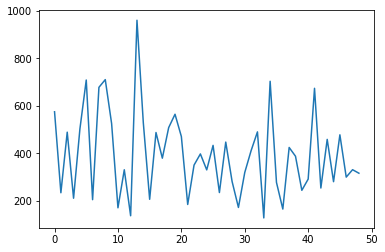

In [12]:
plot_metrics(running_loss)

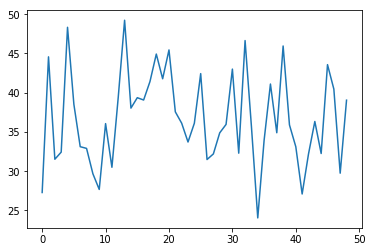

In [13]:
plot_metrics(running_distance)

In [14]:
for i in range(len(dataset)):
    print(i)
    sample = dataset[i]
    print(sample['input'].size(),sample['label'].size())

0
torch.Size([3, 128, 256]) torch.Size([128, 256])
1
torch.Size([3, 128, 256]) torch.Size([128, 256])
2
torch.Size([3, 128, 256]) torch.Size([128, 256])
3
torch.Size([3, 128, 256]) torch.Size([128, 256])
4
torch.Size([3, 128, 256]) torch.Size([128, 256])
5
torch.Size([3, 128, 256]) torch.Size([128, 256])
6
torch.Size([3, 128, 256]) torch.Size([128, 256])
7
torch.Size([3, 128, 256]) torch.Size([128, 256])
8
torch.Size([3, 128, 256]) torch.Size([128, 256])
9
torch.Size([3, 128, 256]) torch.Size([128, 256])
10
torch.Size([3, 128, 256]) torch.Size([128, 256])
11
torch.Size([3, 128, 256]) torch.Size([128, 256])
12
torch.Size([3, 128, 256]) torch.Size([128, 256])
13
torch.Size([3, 128, 256]) torch.Size([128, 256])
14
torch.Size([3, 128, 256]) torch.Size([128, 256])
15
torch.Size([3, 128, 256]) torch.Size([128, 256])
16
torch.Size([3, 128, 256]) torch.Size([128, 256])
17
torch.Size([3, 128, 256]) torch.Size([128, 256])
18
torch.Size([3, 128, 256]) torch.Size([128, 256])
19
torch.Size([3, 128,

torch.Size([3, 128, 256]) torch.Size([128, 256])
178
torch.Size([3, 128, 256]) torch.Size([128, 256])
179
torch.Size([3, 128, 256]) torch.Size([128, 256])
180
torch.Size([3, 128, 256]) torch.Size([128, 256])
181
torch.Size([3, 128, 256]) torch.Size([128, 256])
182
torch.Size([3, 128, 256]) torch.Size([128, 256])
183
torch.Size([3, 128, 256]) torch.Size([128, 256])
184
torch.Size([3, 128, 256]) torch.Size([128, 256])
185
torch.Size([3, 128, 256]) torch.Size([128, 256])
186
torch.Size([3, 128, 256]) torch.Size([128, 256])
187
torch.Size([3, 128, 256]) torch.Size([128, 256])
188
torch.Size([3, 128, 256]) torch.Size([128, 256])
189
torch.Size([3, 128, 256]) torch.Size([128, 256])
190
torch.Size([3, 128, 256]) torch.Size([128, 256])
191
torch.Size([3, 128, 256]) torch.Size([128, 256])
192
torch.Size([3, 128, 256]) torch.Size([128, 256])
193
torch.Size([3, 128, 256]) torch.Size([128, 256])
194
torch.Size([3, 128, 256]) torch.Size([128, 256])


In [15]:
for i, data in enumerate(dataloader):
        # get the inputs
        inputs = data['input']
        labels = data['label']
        labels = labels.unsqueeze(1)

In [2]:
import pickle


In [3]:
history = pickle.load( open( model_history_file, "rb" ) )

In [4]:
print(history)

{'mean_dist': [57.50147523919513, 70.19693564060175, 55.77083745538256, 59.36063040365675, 58.431094817053165, 54.053847190816846, 49.7118234348315, 69.06272238814759, 52.863599473954004, 76.88203524801725, 61.10077144218242, 75.85726991061767, 80.54705091271497, 84.06669477339197, 76.40908955825759, 76.95426326696872, 67.92215978788437, 84.47142089663654, 65.24917090419225, 200.0693987417479, 63.29214170242842, 89.6167948921997, 56.55722270729716, 604.7134104924992, 54.37084628421812, 177.76304675290328, 55.82700335005774, 72.86298568292312, 60.07829782455001, 63.65790754102364, 62.93831635375463, 56.02405924432233, 349.98999436411754, 50.8353175512143, 262.5569827820558, 57.52924180112046, 60.714827127265536, 66.93771930074203, 59.59600892819573, 69.37348242768996, 52.49037308791634, 56.810029153591046, 51.34064973188164, 56.08431021075888, 48.17472073353129, 57.36626595523725, 48.1950458442322, 404.8640958052789, 47.57393487389647, 647.7192257464309, 47.451352615494045, 1320.2569634

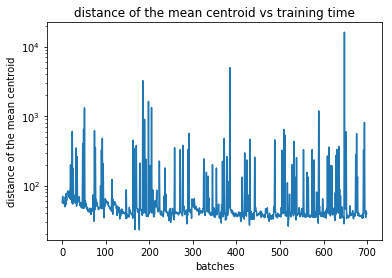

In [18]:
plot_metrics(history['mean_dist'],'distance of the mean centroid')


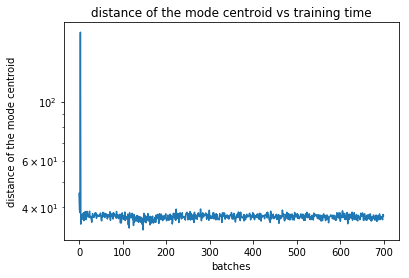

In [19]:
plot_metrics(history['mode_dist'],'distance of the mode centroid')

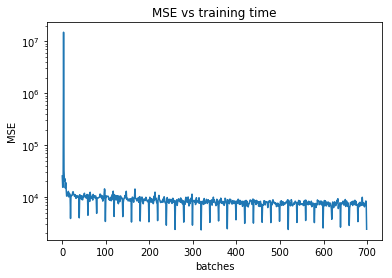

In [20]:
plot_metrics(history['loss'], 'MSE')